In [1]:
import datetime
import configparser
import os

import numpy as np
import pandas as pd

In [2]:
MODEL_NAME='1SM'
MESH_NAME='finest'
DEGREE = 3
CONFIG_NAME = 'comb'
K = 9
ROMBERG_K = 5
GROUNDED_PLATE_AT = -0.088

FILENAME_PATTERN = f'FEM/solutions/paper/{MODEL_NAME}/{MESH_NAME}_{DEGREE}/{CONFIG_NAME}_sampled/{K}/{{name}}.npz'
ES_PREFIX = f'ES/paper_{MODEL_NAME}__{MESH_NAME}_{DEGREE}_{CONFIG_NAME}'

In [3]:
from _dicom import crude_plot_data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cbf

Tworzę elektrody

In [5]:
ELECTRODES = []
for col, x in zip('ABCDE', np.linspace(-6e-3, 6e-3, 5)):
    for row, z in enumerate(np.linspace(0.046, 0.076, 13)):
        ELECTRODES.append({'NAME': f'{col}_{row:02d}',
                           'X': x,
                           'Y': 0.0,
                           'Z': z})
ELECTRODES = pd.DataFrame(ELECTRODES)

In [6]:
class Electrode_kESI(object):
    def __init__(self, filename, decimals_tolerance=None, dx=0):
        self.name = filename[-8:-4]
        self.filename = filename
        self.decimals_tolerance = decimals_tolerance
        self.dx = dx
        with np.load(filename) as fh:
            self._X = self.round(fh['X'])
            self._Y = self.round(fh['Y'])
            self._Z = self.round(fh['Z'])
            self.x, self.y, self.z = fh['LOCATION']
#             try:
            self.base_conductivity = fh['BASE_CONDUCTIVITY']
#             except KeyError:
#                 pass
    
    def round(self, A):
        if self.decimals_tolerance is None:
            return A
        return np.round(A, decimals=self.decimals_tolerance)

    def correction_potential(self, X, Y, Z):
        _X, IDX_X, _ = np.intersect1d(self._X, self.round(X[:, 0, 0]), return_indices=True)
        assert len(_X) == np.shape(X)[0]
        _Y, IDX_Y, _ = np.intersect1d(self._Y, self.round(Y[0, :, 0]), return_indices=True)
        assert len(_Y) == np.shape(Y)[1]
        _Z, IDX_Z, _ = np.intersect1d(self._Z, self.round(Z[0, 0, :]), return_indices=True)
        assert len(_Z) == np.shape(Z)[2]

        with np.load(self.filename) as fh:
            return fh['CORRECTION_POTENTIAL'][np.ix_(IDX_X, IDX_Y, IDX_Z)]

    def base_potential(self, X, Y, Z):
        return (0.25 / (np.pi * self.base_conductivity)
                / (self.dx * 0.15
                   + np.sqrt(np.square(X - self.x)
                             + np.square(Y - self.y)
                             + np.square(Z - self.z))))

        
class Electrode_kCSD(object):
    def __init__(self, filename):
        self.name = filename[-8:-4]
        with np.load(filename) as fh:
            self.x, self.y, self.z = fh['LOCATION']

In [7]:
electrode = Electrode_kESI(FILENAME_PATTERN.format(name='A_00'))

XX = electrode._X
YY = electrode._Y
ZZ = electrode._Z

In [8]:
dx = (XX[-1] - XX[0]) / (len(XX) - 1)
SRC_R_MAX = (2**(ROMBERG_K - 1)) * dx
ROMBERG_N = 2**ROMBERG_K + 1
print(SRC_R_MAX)

NAIVE_R_MAX = 90e-3 - SRC_R_MAX
NAIVE_R_MIN = 31e-3

INFORMED_R_MAX = 79e-3
INFORMED_R_MIN = 67e-3

E_Z_MAX = 76.1e-3
E_Z_MIN = 39.9e-3
E_X_DIST_MAX = 6.0001e-3


X_DIST_MAX = 9e-3
Y_DIST_MAX = 1e-3
print(E_Z_MIN, E_Z_MAX)

0.005625
0.0399 0.0761


In [9]:
X = XX[abs(XX) < X_DIST_MAX + SRC_R_MAX + dx]
Y = YY[abs(YY) < Y_DIST_MAX + SRC_R_MAX + dx]
Z = ZZ[(ZZ < max(NAIVE_R_MAX, INFORMED_R_MAX) + SRC_R_MAX + dx)
      & (ZZ > min(NAIVE_R_MIN, INFORMED_R_MIN) - SRC_R_MAX - dx)]

In [10]:
ELE_NAIVE = ELECTRODES[(ELECTRODES.Z >= E_Z_MIN)
                       & (ELECTRODES.Z <= E_Z_MAX)
                       & (abs(ELECTRODES.X) <= E_X_DIST_MAX)].copy()
print(len(ELE_NAIVE))

_ELE_NAIVE_R2 = np.square(ELE_NAIVE.X) + np.square(ELE_NAIVE.Y) + np.square(ELE_NAIVE.Z)
ELE_INFORMED = ELE_NAIVE[(_ELE_NAIVE_R2 >= np.square(INFORMED_R_MIN))
                          & (_ELE_NAIVE_R2 <= np.square(INFORMED_R_MAX))].copy()
print(len(ELE_INFORMED))

electrodes = {('kesi', len(ELE_INFORMED)): 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_INFORMED.NAME],
              ('kcsd', len(ELE_INFORMED)): 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_INFORMED.NAME],
              ('kesi', len(ELE_NAIVE)): 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_NAIVE.NAME],
              ('kcsd', len(ELE_NAIVE)): 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_NAIVE.NAME],
              }

65
20


Ładuję dane

In [11]:
eigenvalues = {}
eigenvectors = {}
eigensources = {}
images_of_eigensources = {}

for name in ['kesi_informed',
             'kcsd_informed',
             'kesi_naive',
             'kcsd_naive',
             ]:
    with np.load(f'{ES_PREFIX}_{name}_ES_IMAGES_AT_ELECTRODES.npz') as fh:
        images_of_eigensources[name] = {ROW.NAME: fh[ROW.NAME]
                                        for _, ROW in ELECTRODES.iterrows()}

    _eigenvalues = []
    _eigenvectors = []
    _eigensources = []
    
    for i in range(len(images_of_eigensources[name]['A_00'])):
        with np.load(f'{ES_PREFIX}_{name}_ES{i:02d}.npz') as fh:
            _eigenvalues.append(fh['EIGENVALUE'])
            _eigenvectors.append(fh['EIGENVECTOR'])
            _eigensources.append(fh['EIGENSOURCE'])
#             crude_plot_data(fh['CSD'])
            
    eigenvalues[name] = np.array(_eigenvalues)
    eigenvectors[name] = np.transpose(_eigenvectors)
    eigensources[name] = np.transpose(_eigensources)

Sprawdzam rzut znormalizowanych obrazów (FWD) źródeł własnych na wektory własne - spodziewam się znacznej przekątnej.

In [12]:
for name, EIGENVECTORS in eigenvectors.items():
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    IMAGES_NORM = IMAGES_OF_ES / np.sqrt(np.square(IMAGES_OF_ES).sum(axis=0)).reshape(1, -1)
    print(f'{name}\t{abs(np.square(IMAGES_NORM).sum(axis=0) - 1).max():.2e}')
    
    PROJECTION = np.matmul(IMAGES_NORM.T, EIGENVECTORS)
    plt.figure(figsize=(18, 6))
    plt.suptitle(name)

    plt.subplot(1, 2, 1)
    plt.title('EV aliasing')
    plt.imshow(PROJECTION, vmax=1, vmin=-1, cmap=cbf.bwr)
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title('Power preserved')
    plt.stem(np.square(np.diag(PROJECTION)))

KeyError: 'kesi_informed'

(Obrazy w rzędach, wektory własne - w kolumnach)

Aliasing źródeł

In [13]:
for name, images in images_of_eigensources.items():
    IMAGES_OF_ES = np.array([images[e.name]
                             for e in electrodes[name]])
    EIGENVECTORS = eigenvectors[name]
    EIGENVALUES = eigenvalues[name]
#     EXPECTED = np.matmul(EIGENVECTORS,
#                          np.diag(np.sqrt(EIGENVALUES)))
#     ERR = EXPECTED - IMAGES_OF_ES
#     ERR_EV = np.matmul(ERR.T, EIGENVECTORS)
    ERR_EV = np.diag(np.sqrt(EIGENVALUES)) - np.matmul(IMAGES_OF_ES.T, EIGENVECTORS)

    ALIASING = np.matmul(ERR_EV,
                         np.diag(1 / np.sqrt(EIGENVALUES)))
    amp = 0.5  # abs(ALIASING).max()

    plt.figure(figsize=(12, 12))
    plt.title(name)
    plt.imshow(ALIASING,
               vmax=amp,
               vmin=-amp,
               cmap=cbf.bwr)
    plt.plot([0, len(ALIASING) - 1],
             [0, len(ALIASING) - 1],
             ls=':',
             color=cbf.BLACK)
    plt.colorbar()

KeyError: 'kesi_informed'

Normalizacja za pomocą pierwiastka z wartości własnej.

In [14]:
for name in eigenvectors:
    EIGENVECTORS = eigenvectors[name]
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    IMAGES_NORM = np.matmul(IMAGES_OF_ES,
                            np.diag(1./np.sqrt(eigenvalues[name])))
    MTX = np.matmul(IMAGES_NORM.T, EIGENVECTORS)
    amp = abs(MTX).max()
    
    plt.figure(figsize=(18, 6))
    plt.suptitle(name)
    
    plt.subplot(1, 2, 1)
    plt.imshow(MTX,
               vmax=amp,
               vmin=-amp,
               cmap=cbf.bwr)
    plt.plot([0, len(MTX) - 1],
             [0, len(MTX) - 1],
             ls=':',
             color=cbf.BLACK)
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title('power preserved')
    plt.stem(np.square(np.diag(MTX)))
    plt.axhline(1, ls=':', color=cbf.BLACK)
    plt.ylim(0, 1.2)

KeyError: 'kesi_informed'

Sprawdzam (znormalizowane) błędy obrazów w porównaniu z obrazami teoretycznymi (przeskalowane wektory własne).

Chyba bez sensu. :)

In [15]:
for name in eigenvectors:
    EIGENVECTORS = eigenvectors[name]
    EIGENVALUES = eigenvalues[name]
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    
#     IMAGES_NORM = np.matmul(IMAGES_OF_ES,
#                             np.diag(1./np.sqrt(eigenvalues[name])))
#     ERR_NORM = EIGENVECTORS - IMAGES_NORM

    ERR = np.matmul(EIGENVECTORS, np.diag(np.sqrt(EIGENVALUES))) - IMAGES_OF_ES
    ERR_NORM = ERR / np.sqrt(np.square(IMAGES_OF_ES).sum(axis=0)).reshape(1, -1)
    
    amp = abs(ERR_NORM).max()
    
    plt.figure()
    plt.title(name)
    plt.imshow(ERR_NORM, vmin=-amp, vmax=amp, cmap=cbf.bwr)
    plt.colorbar()

KeyError: 'kesi_informed'

Porównanie źródeł własnych kCSD/kESI

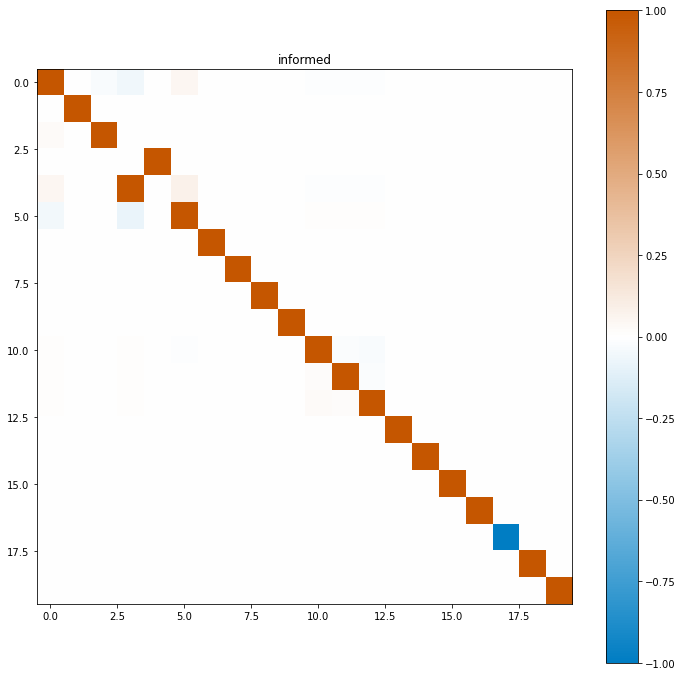

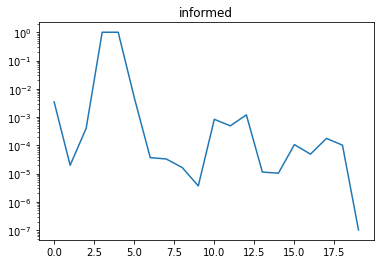

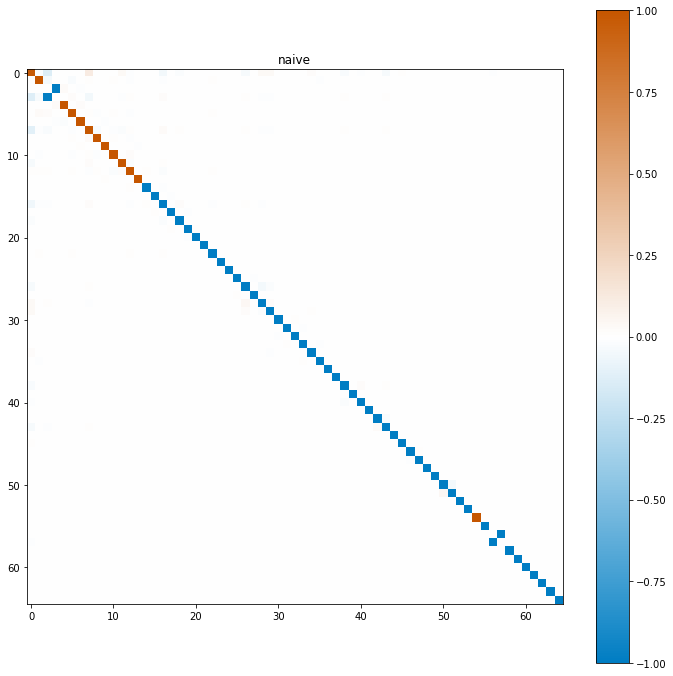

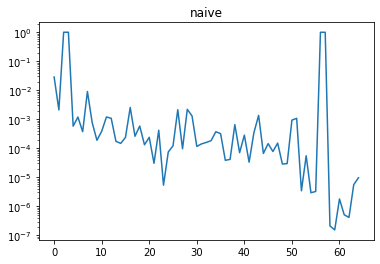

In [13]:
for setup in ['informed',
              'naive',
              ]:
    KCSD_KESI_ES = np.matmul(eigensources[f'kcsd_{setup}'].T,
                             eigensources[f'kesi_{setup}'])
    plt.figure(figsize=(12, 12))
    plt.title(setup)
    plt.imshow(KCSD_KESI_ES,
               cmap=cbf.bwr,
               vmin=-1,
               vmax=1)
    plt.colorbar()
    
    plt.figure()
    plt.title(setup)
    plt.plot(1 - np.diag(abs(KCSD_KESI_ES)))
    plt.yscale('log')

Porównanie wektorów własnych

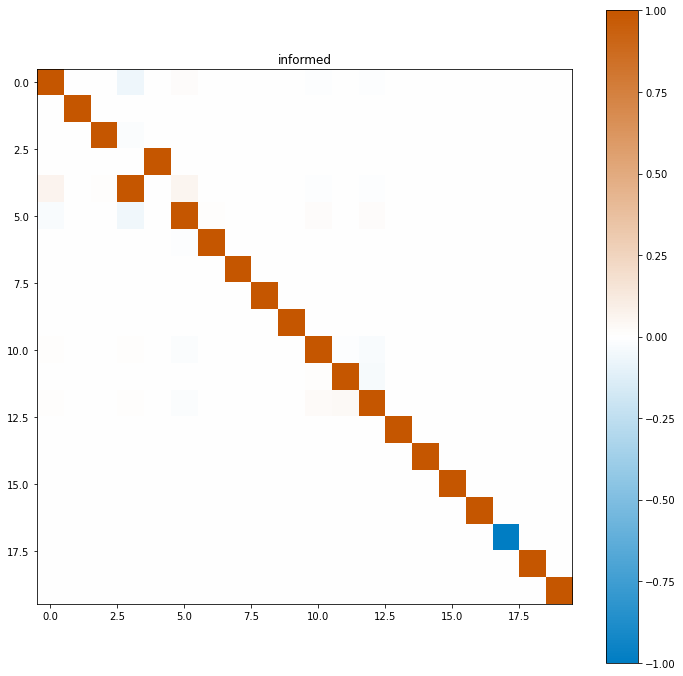

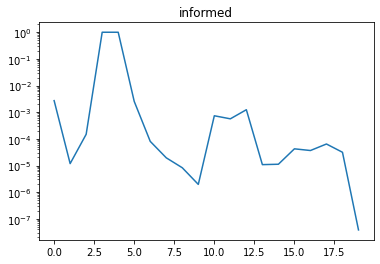

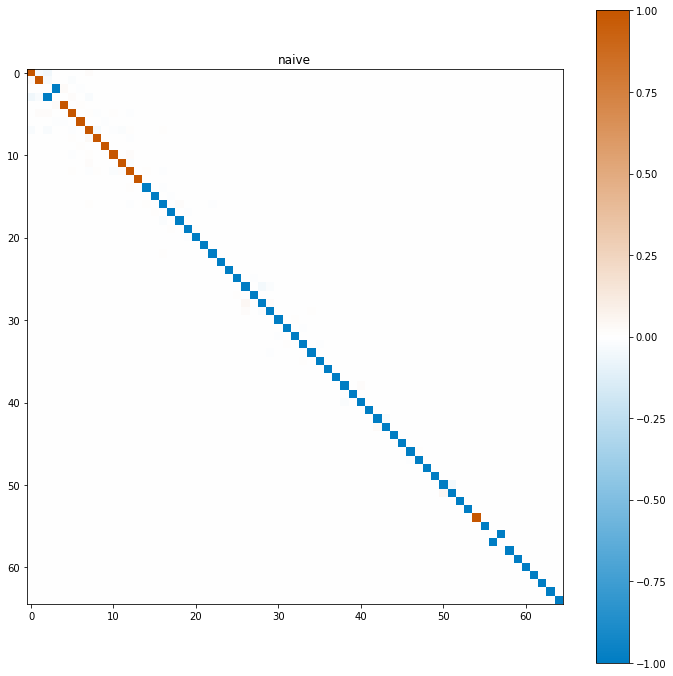

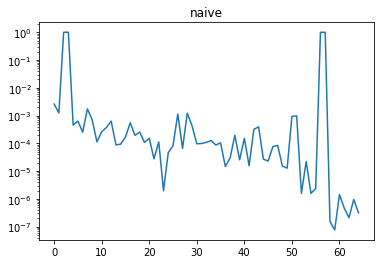

In [14]:
for setup in ['informed',
              'naive',
              ]:
    KCSD_KESI_EV = np.matmul(eigenvectors[f'kcsd_{setup}'].T,
                             eigenvectors[f'kesi_{setup}'])

    plt.figure(figsize=(12, 12))
    plt.title(setup)
    plt.imshow(KCSD_KESI_EV,
               cmap=cbf.bwr,
               vmin=-1,
               vmax=1)
    plt.colorbar()
    
    plt.figure()
    plt.title(setup)
    plt.plot(1 - np.diag(abs(KCSD_KESI_EV)))
    plt.yscale('log')

# Sprawdzenie odtwarzalności źródeł

In [15]:
import _fast_reciprocal_reconstructor as frr
import _common_new as common

In [16]:
# arc = np.arctan(abs(ELE.X / ELE.Z).max())
arc = np.arctan(E_X_DIST_MAX / INFORMED_R_MIN)
print(f'{arc / np.pi * 180} deg')

5.117399685701221 deg


In [17]:
def inflate(A):
    B = np.empty(2 * len(A) - 1)
    B[::2] = A
    B[1::2] = 0.5 * (A[:-1] + A[1:])
    return B

In [18]:
convolver = frr.ckESI_convolver([X,
                                 Y,
                                 Z],
                                [inflate(X),
#                                  np.array([0.]),
                                 inflate(Y),
                                 inflate(Z)])

In [19]:
conductivity = 0.33
# sd = convolver.ds('POT')[0] * 16 / 6
sd = SRC_R_MAX / 3
model_src = common.SphericalSplineSourceKCSD(0, 0, 0,
                                             [sd, 3 * sd],
                                             [[1],
                                              [0,
                                               2.25 / sd,
                                               -1.5 / sd ** 2,
                                               0.25 / sd ** 3]],
                                             conductivity)
print(3 * sd)

0.005625


In [20]:
SRC_R2 = (np.square(convolver.SRC_X)
          + np.square(convolver.SRC_Y)
          + np.square(convolver.SRC_Z))
SRC_IDX_NAIVE = ((SRC_R2 >= NAIVE_R_MIN ** 2)
                 & (SRC_R2 <= NAIVE_R_MAX ** 2)
                 & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                 )

SRC_IDX_INFORMED = ((SRC_R2 >= INFORMED_R_MIN ** 2)
                    & (SRC_R2 <= INFORMED_R_MAX ** 2)
                    & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                    & (((convolver.SRC_X * 0
                        + convolver.SRC_Y * 0
                        + convolver.SRC_Z
                        / np.sqrt(SRC_R2)) >= np.cos(arc)))
                   )
source_idx = {'naive': SRC_IDX_NAIVE,
              'informed': SRC_IDX_INFORMED}

In [21]:
CSD_R2 = (np.square(convolver.CSD_X)
          + np.square(convolver.CSD_Y)
          + np.square(convolver.CSD_Z))
CSD_IDX = CSD_R2 <= 0.090 ** 2

In [22]:
POT_R2 = (np.square(convolver.POT_X)
          + np.square(convolver.POT_Y)
          + np.square(convolver.POT_Z))
POT_ALLOWED = POT_R2 <= 0.090 ** 2

In [23]:
kernels = {}

for (method, n_electrodes), _electrodes in electrodes.items():
    try:
        _kernels = kernels[n_electrodes]
    except KeyError:
        _kernels = kernels[n_electrodes] = {}

    for _sources, SRC_IDX in source_idx.items():
        print(n_electrodes, method, _sources)
        _kernels[f'{method}_{_sources}'] = frr.ckESI_kernel_constructor(
                                           model_src,
                                           convolver,
                                           SRC_IDX,
                                           CSD_IDX,
                                           _electrodes,
                                           weights=ROMBERG_N)


20 kesi naive
20 kesi informed
20 kcsd naive
20 kcsd informed
65 kesi naive
65 kesi informed
65 kcsd naive
65 kcsd informed


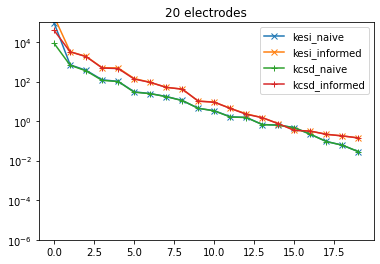

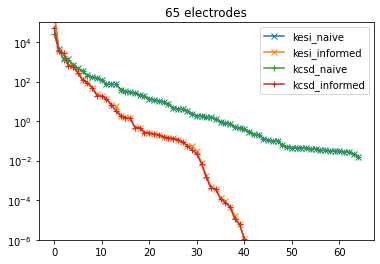

In [24]:
for n_electrodes, _kernels in kernels.items():
    plt.figure()
    plt.title(f'{n_electrodes} electrodes')
    
    for label, ks in _kernels.items():
        _ev = np.linalg.eigvalsh(ks.kernel)[::-1]
        plt.plot(_ev,
                 marker='x' if label[:4] == 'kesi' else '+',
                 label=label)

    plt.ylim(1e-6, 1e5)
    plt.yscale('log')
    plt.legend(loc='best')

In [25]:
regularization_parameters = np.logspace(-3, 5, 41)

In [26]:
import kesi
import kesi._verbose as verbose

Test na wektorach własnych

In [27]:
ns = {_n: {name: len(ks._pre_kernel)
           for name, ks in _kernels.items()}
      for _n, _kernels in kernels.items()}

_eigh = {_n: {name: np.linalg.eigh(ks.kernel * ns[_n][name])
           for name, ks in _kernels.items()}
         for _n, _kernels in kernels.items()}

own_eigenvectors = {_n: {name: _ev[1][:, ::-1]
                   for name, _ev in _eigh_n.items()}
                 for _n, _eigh_n in _eigh.items()}
own_eigenvalues = {_n: {name: _ev[0][::-1]
                   for name, _ev in _eigh_n.items()}
                 for _n, _eigh_n in _eigh.items()}


reconstructors = {_n:  {name: verbose.VerboseFFR._CrossKernelReconstructor(
                                kesi._engine._LinearKernelSolver(
                                    ks.kernel),
                                np.matmul(np.diag(np.sqrt(own_eigenvalues[_n][name])
                                                  / ns[_n][name]),
                                          own_eigenvectors[_n][name].T))
                      for name, ks in _kernels.items()}
                  for _n, _kernels in kernels.items()}

/home/jkowalski/anaconda3/envs/kesi36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


/home/jkowalski/anaconda3/envs/kesi36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/jkowalski/anaconda3/envs/kesi36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


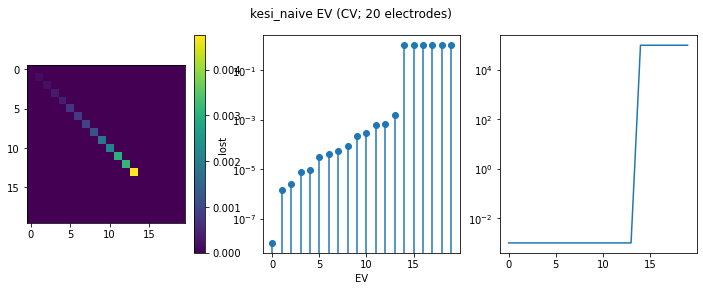

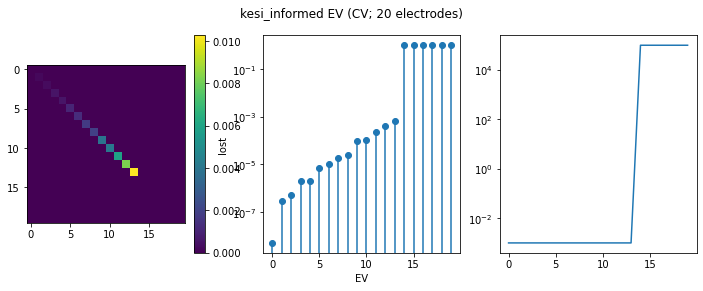

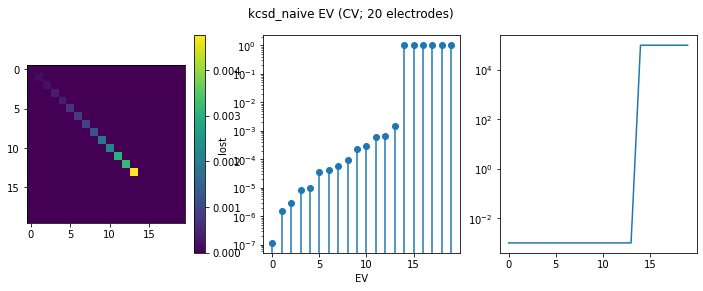

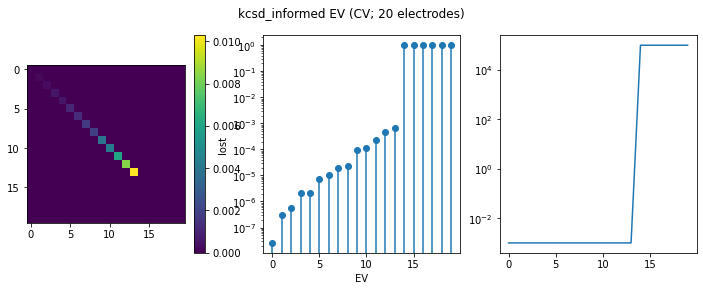

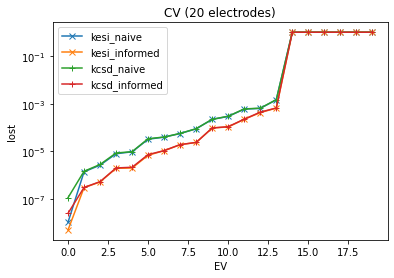

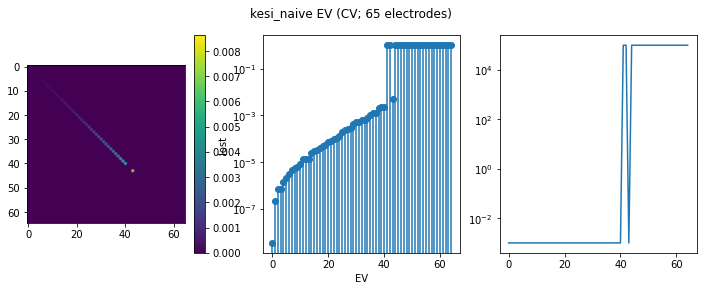

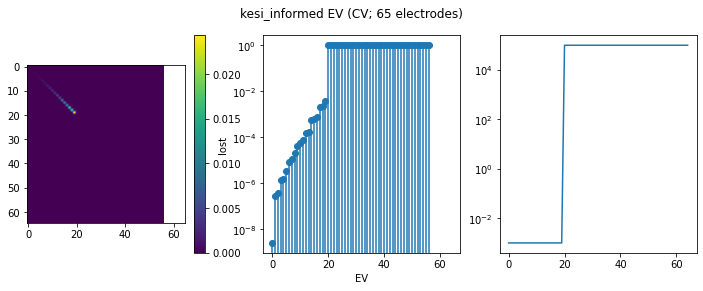

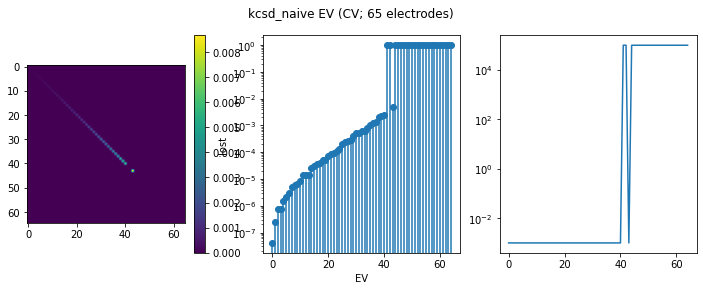

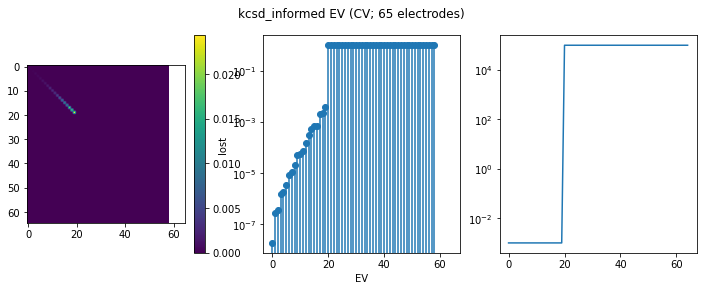

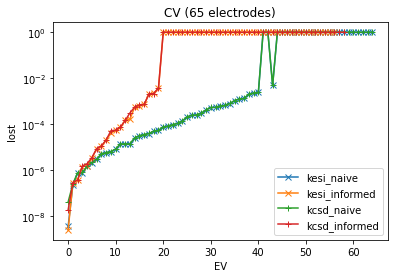

In [33]:
for _n, _reconstructors in reconstructors.items():
    preserved = {}
    
    for name, reconstructor in _reconstructors.items():
        rps = []
        reconstruction = []

        for i, POTENTIAL in enumerate(own_eigenvectors[_n][name].T):
            POTENTIAL = POTENTIAL.copy()
        #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
        #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
            errors = common.cv(reconstructor, POTENTIAL, regularization_parameters)
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            rps.append(regularization_parameter)
            reconstruction.append(
                reconstructor(POTENTIAL,
                              regularization_parameter=regularization_parameter))

            
        preserved[name] = (np.diag(reconstruction)
                           * np.sqrt(own_eigenvalues[_n][name]))
    
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'{name} EV (CV; {_n} electrodes)')

        plt.subplot(1, 3, 1)
        plt.imshow(reconstruction)
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.stem(abs(1 - preserved[name]))
        plt.yscale('log')
        plt.ylabel('lost')
        plt.xlabel('EV')

        plt.subplot(1, 3, 3)
        plt.plot(rps)
        plt.yscale('log')
        
    plt.figure()
    plt.title(f'CV ({_n} electrodes)')
    plt.yscale('log')
    plt.ylabel('lost')
    plt.xlabel('EV')
    
    for name, PRESERVED in preserved.items():
        plt.plot(abs(1 - PRESERVED),
                 label=name,
                 marker='x' if name[:4] == 'kesi' else '+',
                 )
    
    plt.legend(loc='best')

Optymalny dobór regularyzacji

/home/jkowalski/anaconda3/envs/kesi36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/home/jkowalski/anaconda3/envs/kesi36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


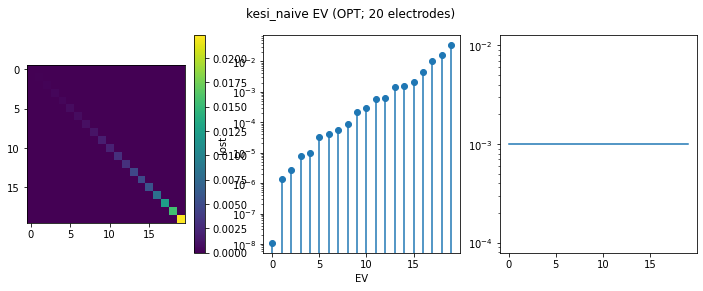

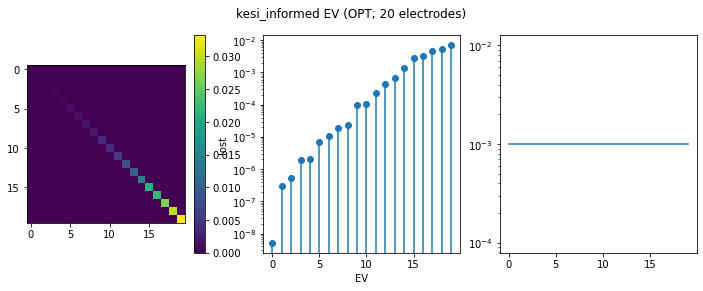

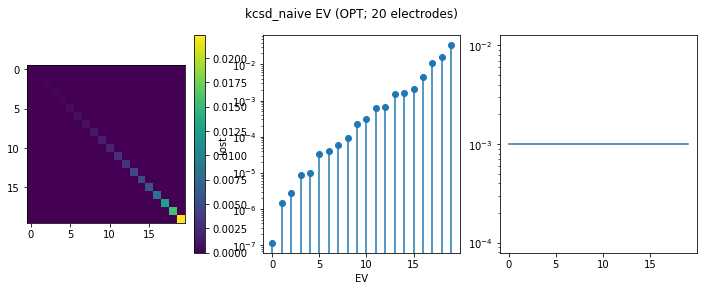

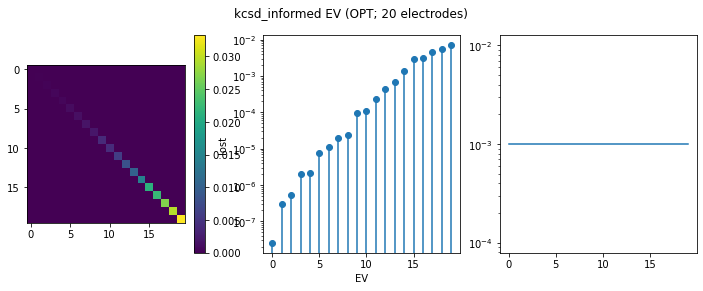

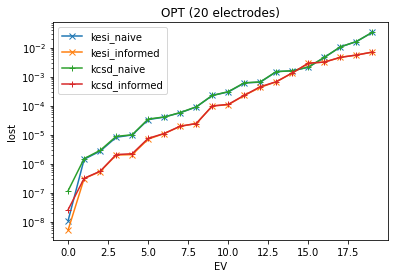

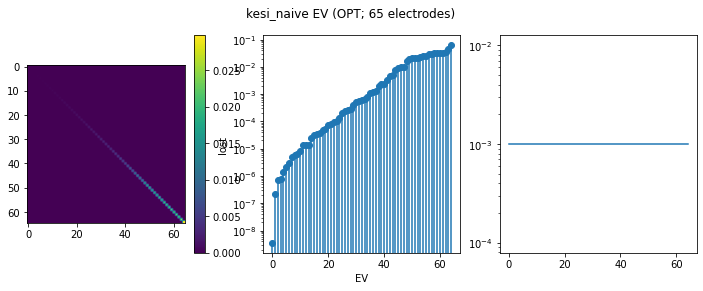

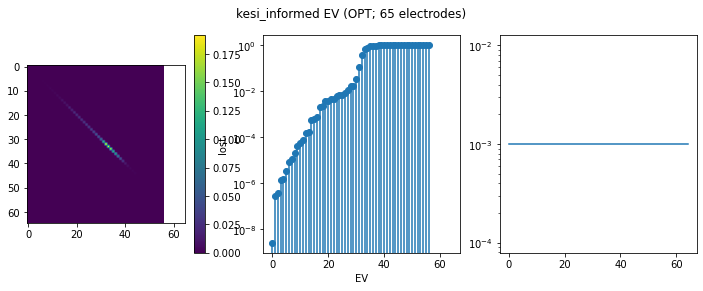

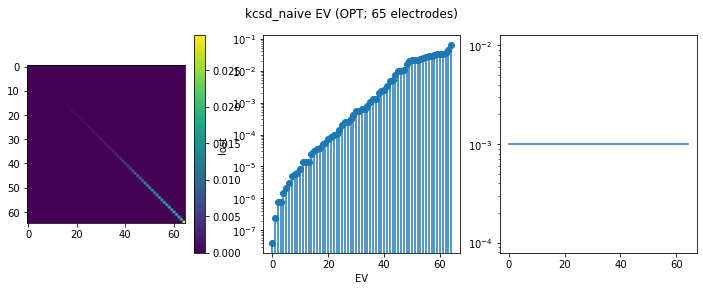

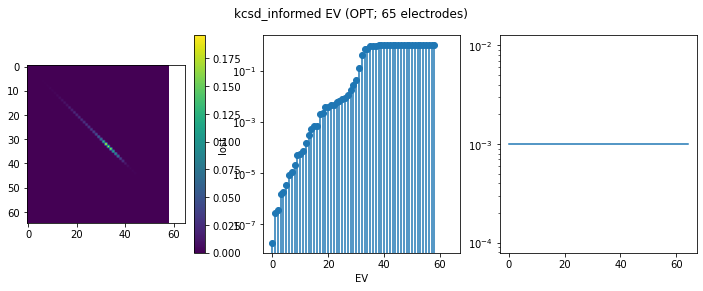

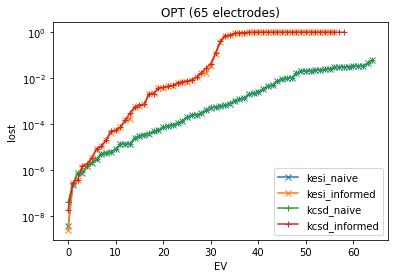

In [35]:
for _n, _reconstructors in reconstructors.items():
    preserved = {}
    
    for name, reconstructor in _reconstructors.items():
        rps = []
        reconstruction = []

        for i, POTENTIAL in enumerate(own_eigenvectors[_n][name].T):
            POTENTIAL = POTENTIAL.copy()
        #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
        #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
            errors = [abs(reconstructor(POTENTIAL, regularization_parameter=r)[i] - 1)
                      for r in regularization_parameters]
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            rps.append(regularization_parameter)
            reconstruction.append(
                reconstructor(POTENTIAL,
                              regularization_parameter=regularization_parameter))

            
        preserved[name] = (np.diag(reconstruction)
                           * np.sqrt(own_eigenvalues[_n][name]))
    
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'{name} EV (OPT; {_n} electrodes)')

        plt.subplot(1, 3, 1)
        plt.imshow(reconstruction)
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.stem(abs(1 - preserved[name]))
        plt.yscale('log')
        plt.ylabel('lost')
        plt.xlabel('EV')

        plt.subplot(1, 3, 3)
        plt.plot(rps)
        plt.yscale('log')
        
    plt.figure()
    plt.title(f'OPT ({_n} electrodes)')
    plt.yscale('log')
    plt.ylabel('lost')
    plt.xlabel('EV')
    
    for name, PRESERVED in preserved.items():
        plt.plot(abs(1 - PRESERVED),
                 label=name,
                 marker='x' if name[:4] == 'kesi' else '+',
                 )
    
    plt.legend(loc='best')

# for _n, _reconstructors in reconstructors.items():
#     for name, reconstructor in _reconstructors.items():
#         rps = []
#         reconstruction = []

#         for i, POTENTIAL in enumerate(eigenvectors[name].T):
#             POTENTIAL = POTENTIAL.copy()
#         #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
#         #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
#             errors = [abs(reconstructor(POTENTIAL, regularization_parameter=r)[i] - 1)
#                       for r in regularization_parameters]
#             regularization_parameter = regularization_parameters[np.argmin(errors)]
#             rps.append(regularization_parameter)
#             reconstruction.append(
#                 reconstructor(POTENTIAL,
#                               regularization_parameter=regularization_parameter))

#         plt.figure(figsize=(12, 4))
#         plt.suptitle(f'{name} EV (OPT; {_n})')

#         plt.subplot(1, 3, 1)
#         plt.imshow(reconstruction)
#         plt.colorbar()

#         plt.subplot(1, 3, 2)
#         plt.stem(abs(1 - np.diag(reconstruction)
#                          * np.sqrt(eigenvalues[name])))
#         plt.yscale('log')

#         plt.subplot(1, 3, 3)
#         plt.plot(rps)
#         plt.yscale('log')

Odtworzenie źródeł własnych z ich obrazów

`POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())` to normalizacja przez pierwiastek wartości własnej modelu idealnego.

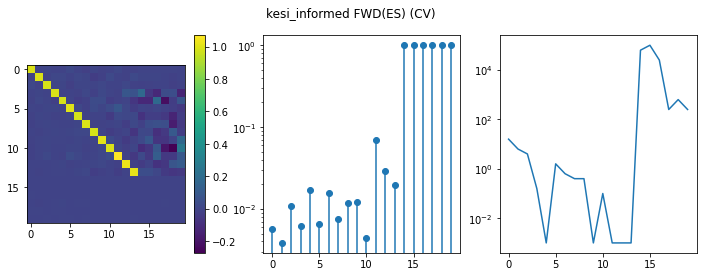

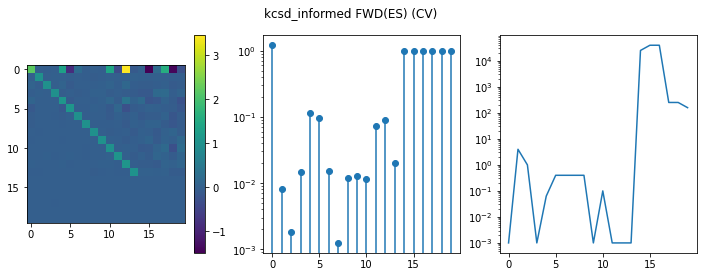

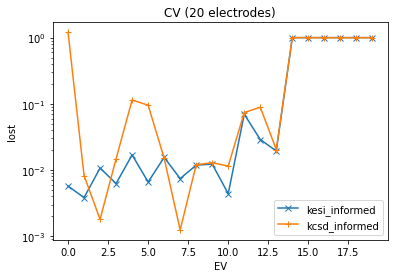

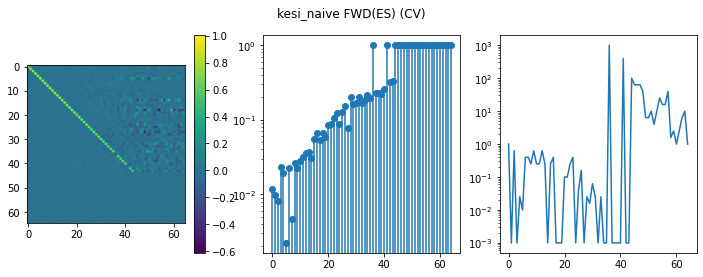

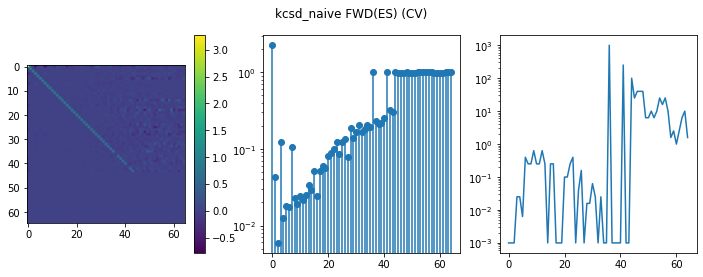

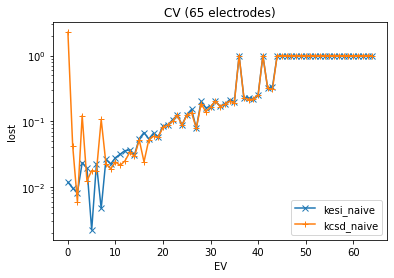

In [37]:
for _n, _reconstructors in reconstructors.items():
    preserved = {}

    for name, reconstructor in _reconstructors.items():
        if (_n, name[5:]) in [(20, 'naive'),
                              (65, 'informed')]:
            continue

        rps = []
        reconstruction = []

        IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                                 for e in electrodes[(name[:4], _n)]])

        for i, POTENTIAL in enumerate(IMAGES_OF_ES.T):
            POTENTIAL = POTENTIAL.copy()
        #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
        #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
            errors = common.cv(reconstructor, POTENTIAL, regularization_parameters)
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            rps.append(regularization_parameter)
            reconstruction.append(
                reconstructor(POTENTIAL,
                              regularization_parameter=regularization_parameter))
            
        preserved[name] = np.diag(reconstruction)

        plt.figure(figsize=(12, 4))
        plt.suptitle(f'{name} FWD(ES) (CV)')

        plt.subplot(1, 3, 1)
        plt.imshow(reconstruction)
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.stem(abs(1 - preserved[name]))
        plt.yscale('log')

        plt.subplot(1, 3, 3)
        plt.plot(rps)
        plt.yscale('log')
        
    plt.figure()
    plt.title(f'CV ({_n} electrodes)')
    plt.yscale('log')
    plt.ylabel('lost')
    plt.xlabel('EV')
    
    for name, PRESERVED in preserved.items():
        plt.plot(abs(1 - PRESERVED),
                 label=name,
                 marker='x' if name[:4] == 'kesi' else '+',
                 )
    
    plt.legend(loc='best')

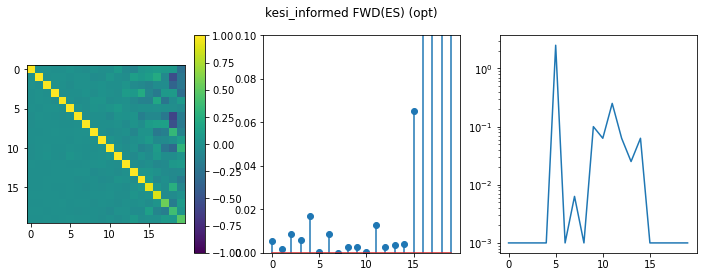

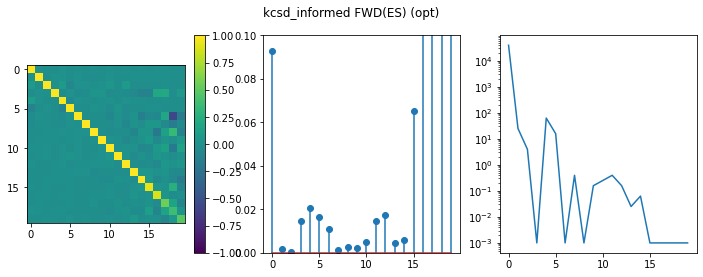

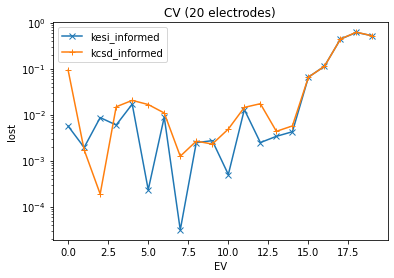

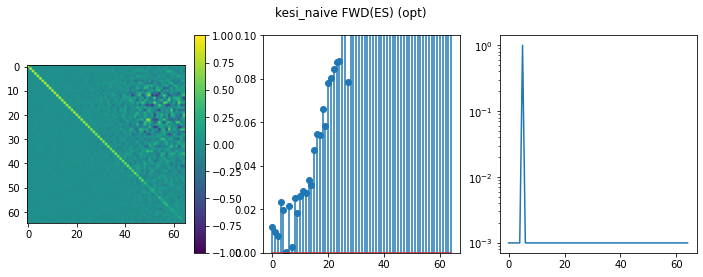

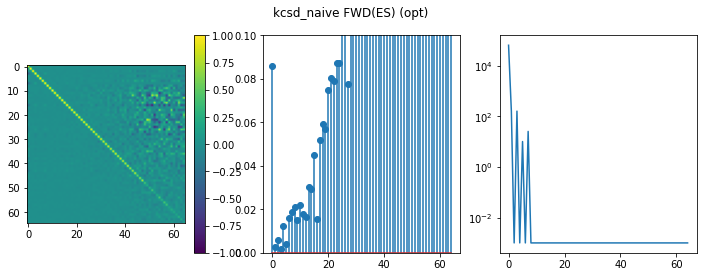

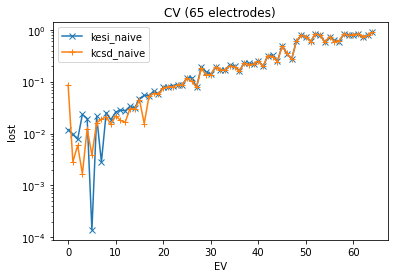

In [39]:
for _n, _reconstructors in reconstructors.items():
    preserved = {}

    for name, reconstructor in _reconstructors.items():
        if (_n, name[5:]) in [(20, 'naive'),
                              (65, 'informed')]:
            continue

        rps = []
        reconstruction = []

        IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                                 for e in electrodes[(name[:4], _n)]])

        for i, POTENTIAL in enumerate(IMAGES_OF_ES.T):
            POTENTIAL = POTENTIAL.copy()
        #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
        #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
            errors = [abs(reconstructor(POTENTIAL, regularization_parameter=r)[i] - 1)
                      for r in regularization_parameters]
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            rps.append(regularization_parameter)
            reconstruction.append(
                reconstructor(POTENTIAL,
                              regularization_parameter=regularization_parameter))

        preserved[name] = np.diag(reconstruction)

        plt.figure(figsize=(12, 4))
        plt.suptitle(f'{name} FWD(ES) (opt)')

        plt.subplot(1, 3, 1)
        plt.imshow(reconstruction, vmin=-1, vmax=1)
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.stem(abs(1 - preserved[name]))
        plt.ylim(0, 0.1)
    #     plt.yscale('log')

        plt.subplot(1, 3, 3)
        plt.plot(rps)
        plt.yscale('log')
        
    plt.figure()
    plt.title(f'CV ({_n} electrodes)')
    plt.yscale('log')
    plt.ylabel('lost')
    plt.xlabel('EV')
    
    for name, PRESERVED in preserved.items():
        plt.plot(abs(1 - PRESERVED),
                 label=name,
                 marker='x' if name[:4] == 'kesi' else '+',
                 )
    
    plt.legend(loc='best')

# test rekonstruktorów

In [41]:
reconstructors_csd = {_n: {name: verbose.VerboseFFR._CrossKernelReconstructor(
                                    kesi._engine._LinearKernelSolver(
                                        ks.kernel),
                                    ks.cross_kernel)
                           for name, ks in _kernels.items()}
                      for _n, _kernels in kernels.items()}

In [43]:
def wrap_csd(DATA):
    WRAPPED = np.zeros(convolver.shape('CSD'))
    WRAPPED[CSD_IDX] = DATA
    return WRAPPED

In [45]:
def rmse(A, B):
    return np.sqrt(np.square(A - B).mean())

In [47]:
RECONSTRUCTOR_STATS = []

for name in ['kcsd_informed',
             'kcsd_naive']:

    n_electrodes = len(eigenvalues[name])
    
    for i in range(n_electrodes):
        with np.load(f'{ES_PREFIX}_{name}_ES{i:02d}.npz') as fh:
            XYZ = [fh[c] for c in 'XYZ']
            CSD = fh['CSD']  # [:, XYZ[1] == 0, :]

        amp = abs(CSD).max()
        row = {'SOURCES': name[5:],
               'N_ELECTRODES': n_electrodes,
               'CSD_AMP': amp,
               'ES': i,
               }

        for rec_name, rec in reconstructors_csd[n_electrodes].items():
            POTENTIAL = np.array([images_of_eigensources[name][e.name][i]
                                  for e in electrodes[rec_name[:4], n_electrodes]])

            row[f'RMSE_{rec_name}_0'] = rmse(CSD, wrap_csd(rec(POTENTIAL))) / amp

            errors = common.cv(rec, POTENTIAL, regularization_parameters)
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            row[f'RMSE_{rec_name}_CV'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                              regularization_parameter=regularization_parameter))) / amp
            row[f'RP_{rec_name}_OPT'] = regularization_parameter

            errors = [rmse(CSD, wrap_csd(rec(POTENTIAL, regularization_parameter=r)))
                      for r in regularization_parameters]
            regularization_parameter = regularization_parameters[np.argmin(errors)]
            row[f'RMSE_{rec_name}_OPT'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                              regularization_parameter=regularization_parameter))) / amp
            row[f'RP_{rec_name}_OPT'] = regularization_parameter
        
        RECONSTRUCTOR_STATS.append(row)
    
RECONSTRUCTOR_STATS = pd.DataFrame(RECONSTRUCTOR_STATS)

In [49]:
RECONSTRUCTOR_STATS

,SOURCES,N_ELECTRODES,CSD_AMP,ES,RMSE_kesi_naive_0,RMSE_kesi_naive_CV,RP_kesi_naive_OPT,RMSE_kesi_naive_OPT,RMSE_kesi_informed_0,RMSE_kesi_informed_CV,RP_kesi_informed_OPT,RMSE_kesi_informed_OPT,RMSE_kcsd_naive_0,RMSE_kcsd_naive_CV,RP_kcsd_naive_OPT,RMSE_kcsd_naive_OPT,RMSE_kcsd_informed_0,RMSE_kcsd_informed_CV,RP_kcsd_informed_OPT,RMSE_kcsd_informed_OPT
0,informed,20,1.043037e+08,0,0.033022,0.033014,0.063096,0.032873,0.004696,0.002715,39.810717,0.001482,0.120092,0.120085,10000.000000,0.077491,0.149856,0.149838,39810.717055,0.010624
1,informed,20,8.720582e+07,1,0.021067,0.016834,0.398107,0.016723,0.007586,0.002513,25.118864,0.002216,0.021413,0.017214,0.398107,0.017088,0.008038,0.003252,39.810717,0.002389
2,informed,20,8.240860e+07,2,0.018326,0.017509,0.039811,0.017394,0.005479,0.002406,3.981072,0.002406,0.021304,0.020683,0.039811,0.020621,0.014612,0.013335,39.810717,0.013063
3,informed,20,6.196761e+07,3,0.017909,0.017866,0.039811,0.017363,0.008083,0.008070,2.511886,0.005102,0.018019,0.017978,0.039811,0.017546,0.008557,0.008546,3.981072,0.006069
4,informed,20,8.375967e+07,4,0.013779,0.013718,0.100000,0.012244,0.007224,0.004551,3.981072,0.002524,0.019185,0.019144,0.063096,0.018304,0.018725,0.018300,25.118864,0.015553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,naive,65,8.210751e+06,60,0.103769,0.119581,0.001000,0.104345,8353.136604,0.121191,100000.000000,0.117260,0.105154,0.121183,0.001000,0.105732,7722.870854,0.125482,100000.000000,0.117283
81,naive,65,9.367808e+06,61,0.088071,0.088034,100000.000000,0.085570,14179.147018,0.089329,25118.864315,0.085569,0.088046,0.088041,100000.000000,0.085570,4272.716918,0.086054,100000.000000,0.085574
82,naive,65,7.325965e+06,62,0.136704,0.160617,0.001000,0.137585,58003.364394,0.170401,100000.000000,0.159123,0.137489,0.161267,0.001000,0.138364,15918.485886,0.165383,100000.000000,0.159120
83,naive,65,7.182092e+06,63,0.127838,0.156972,0.001000,0.128596,26433.912706,0.156512,1584.893192,0.155923,0.128605,0.157331,0.001000,0.129365,25218.523947,0.156752,1584.893192,0.156060


kesi_informed (65 electrodes) out of plot
kcsd_informed (65 electrodes) out of plot


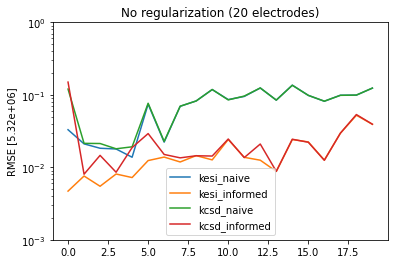

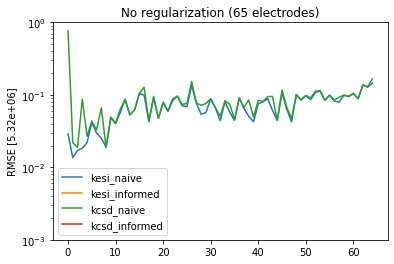

In [51]:
for _n, TMP in RECONSTRUCTOR_STATS.groupby('N_ELECTRODES'):
    plt.figure()
    plt.title(f'No regularization ({_n} electrodes)')
    for name in reconstructors_csd[_n]:
        RMSE = TMP[f'RMSE_{name}_0']
        plt.plot(TMP.ES,
                 RMSE,
                 label=name)
        if (RMSE >= 1).all() or (RMSE <= 1e-3).all():
            print(f'{name} ({_n} electrodes) out of plot')

    plt.legend(loc='best')
    plt.yscale('log')
    plt.ylim(1e-3, 1)
    plt.ylabel(f'RMSE [{amp:.2e}]')

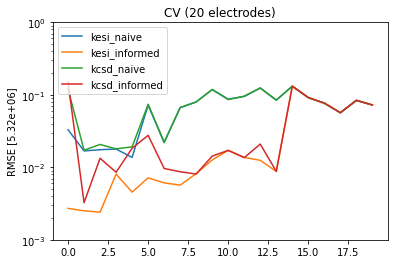

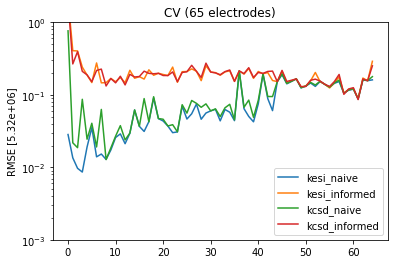

In [53]:
for _n, TMP in RECONSTRUCTOR_STATS.groupby('N_ELECTRODES'):
    plt.figure()
    plt.title(f'CV ({_n} electrodes)')
    for name in reconstructors_csd[_n]:
        plt.plot(TMP.ES,
                 TMP[f'RMSE_{name}_CV'],
                 label=name)

    plt.legend(loc='best')
    plt.yscale('log')
    plt.ylim(1e-3, 1)
    plt.ylabel(f'RMSE [{amp:.2e}]')

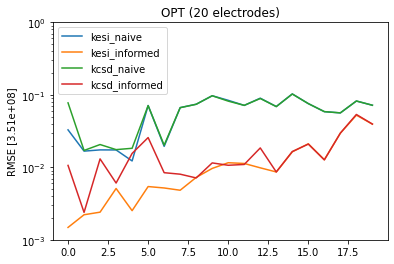

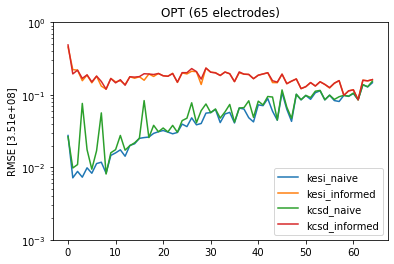

In [55]:
for _n, TMP in RECONSTRUCTOR_STATS.groupby('N_ELECTRODES'):
    plt.figure()
    plt.title(f'OPT ({_n} electrodes)')
    for name in reconstructors_csd[_n]:
        plt.plot(TMP.ES,
                 TMP[f'RMSE_{name}_OPT'],
                 label=name)

    plt.legend(loc='best')
    plt.yscale('log')
    plt.ylim(1e-3, 1)
    plt.ylabel(f'RMSE [{amp:.2e}]')

# testy mieszanek

In [57]:
N_ES = 15
N_TEST = 100

In [58]:
weights = np.random.normal(size=(N_TEST, N_ES))

In [59]:
for name in ['kcsd_informed',
             'kcsd_naive']:

    n_electrodes = len(eigenvalues[name])
    print(name, n_electrodes)

kcsd_informed 20
kcsd_naive 65


In [60]:
TEST_RESULTS = []

for name in ['kcsd_informed',
             'kcsd_naive']:

    es_n_electrodes = len(eigenvalues[name])

    for j, row_weight in enumerate(weights):
        print(f'{name}\t{j:d}\t{j / N_TEST:.2f}')
        CSD = 0.0

        for i, w in enumerate(row_weight):
            with np.load(f'{ES_PREFIX}_{name}_ES{i:02d}.npz') as fh:
                XYZ = [fh[c] for c in 'XYZ']
                CSD += w * fh['CSD']

        for rec_n_electrodes, _reconstructors in reconstructors_csd.items():
            POTENTIAL = 0.0
            for i, w in enumerate(row_weight):
                POTENTIAL += w * np.array([images_of_eigensources[name][e.name][i]
                                          for e in electrodes['kcsd', rec_n_electrodes]])

            amp = abs(CSD).max()
            row = {'SOURCES': name[5:],
                   'ES_N_ELECTRODES': es_n_electrodes,
                   'REC_N_ELECTRODES': rec_n_electrodes,
                   'CSD_AMP': amp,
                   }

            for i, w in enumerate(row_weight):
                row[f'ES_{i:02d}'] = w        

            for rec_name, rec in _reconstructors.items():
                row[f'RMSE_{rec_name}_0'] = rmse(CSD, wrap_csd(rec(POTENTIAL))) / amp

                errors = common.cv(rec, POTENTIAL, regularization_parameters)
                regularization_parameter = regularization_parameters[np.argmin(errors)]
                row[f'RMSE_{rec_name}_CV'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                                  regularization_parameter=regularization_parameter))) / amp
                row[f'RP_{rec_name}_OPT'] = regularization_parameter

                errors = [rmse(CSD, wrap_csd(rec(POTENTIAL, regularization_parameter=r)))
                          for r in regularization_parameters]
                regularization_parameter = regularization_parameters[np.argmin(errors)]
                row[f'RMSE_{rec_name}_OPT'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                                  regularization_parameter=regularization_parameter))) / amp
                row[f'RP_{rec_name}_OPT'] = regularization_parameter

            TEST_RESULTS.append(row)
    
TEST_RESULTS = pd.DataFrame(TEST_RESULTS)

kcsd_informed	0	0.00
kcsd_informed	1	0.01
kcsd_informed	2	0.02
kcsd_informed	3	0.03
kcsd_informed	4	0.04
kcsd_informed	5	0.05
kcsd_informed	6	0.06
kcsd_informed	7	0.07
kcsd_informed	8	0.08
kcsd_informed	9	0.09
kcsd_informed	10	0.10
kcsd_informed	11	0.11
kcsd_informed	12	0.12
kcsd_informed	13	0.13
kcsd_informed	14	0.14
kcsd_informed	15	0.15
kcsd_informed	16	0.16
kcsd_informed	17	0.17
kcsd_informed	18	0.18
kcsd_informed	19	0.19
kcsd_informed	20	0.20
kcsd_informed	21	0.21
kcsd_informed	22	0.22
kcsd_informed	23	0.23
kcsd_informed	24	0.24
kcsd_informed	25	0.25
kcsd_informed	26	0.26
kcsd_informed	27	0.27
kcsd_informed	28	0.28
kcsd_informed	29	0.29
kcsd_informed	30	0.30
kcsd_informed	31	0.31
kcsd_informed	32	0.32
kcsd_informed	33	0.33
kcsd_informed	34	0.34
kcsd_informed	35	0.35
kcsd_informed	36	0.36
kcsd_informed	37	0.37
kcsd_informed	38	0.38
kcsd_informed	39	0.39
kcsd_informed	40	0.40
kcsd_informed	41	0.41
kcsd_informed	42	0.42
kcsd_informed	43	0.43
kcsd_informed	44	0.44
kcsd_informed	45	0.4

In [61]:
TEST_RESULTS

,SOURCES,ES_N_ELECTRODES,REC_N_ELECTRODES,CSD_AMP,ES_00,ES_01,ES_02,ES_03,ES_04,ES_05,...,RP_kesi_informed_OPT,RMSE_kesi_informed_OPT,RMSE_kcsd_naive_0,RMSE_kcsd_naive_CV,RP_kcsd_naive_OPT,RMSE_kcsd_naive_OPT,RMSE_kcsd_informed_0,RMSE_kcsd_informed_CV,RP_kcsd_informed_OPT,RMSE_kcsd_informed_OPT
0,informed,20,20,2.330347e+08,1.356511,-0.427106,-0.595039,0.267441,0.704125,-0.389995,...,0.251189,0.004215,0.078766,0.078750,10000.000000,0.074131,0.091538,0.091526,63095.734448,0.063009
1,informed,20,65,2.330347e+08,1.356511,-0.427106,-0.595039,0.267441,0.704125,-0.389995,...,0.398107,0.004828,0.081003,0.080978,0.158489,0.080385,164.858146,0.145617,100000.000000,0.061104
2,informed,20,20,3.142843e+08,-0.206446,1.771344,-1.161515,0.417336,0.824356,0.772297,...,0.630957,0.002964,0.033095,0.032433,0.063096,0.032433,0.014140,0.012933,1.000000,0.011767
3,informed,20,65,3.142843e+08,-0.206446,1.771344,-1.161515,0.417336,0.824356,0.772297,...,1.000000,0.004005,0.022118,0.024219,0.003981,0.022065,75.442918,0.024350,15.848932,0.022224
4,informed,20,20,2.711476e+08,0.174254,1.343358,-1.324015,0.539957,1.557610,0.546927,...,0.630957,0.001977,0.034815,0.034319,0.063096,0.034319,0.015015,0.015006,1.000000,0.013362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,naive,65,65,1.909695e+08,-0.148248,-0.562049,-0.861389,-0.323455,0.593640,0.506209,...,251.188643,0.171553,0.074420,0.072412,10.000000,0.055715,24276.003467,0.228666,398.107171,0.193922
396,naive,65,20,3.689591e+08,-0.507260,0.691764,0.442520,0.281356,1.342009,-0.487949,...,0.158489,0.108211,0.108483,0.108476,2.511886,0.107350,0.109413,0.109408,0.158489,0.109167
397,naive,65,65,3.689591e+08,-0.507260,0.691764,0.442520,0.281356,1.342009,-0.487949,...,2511.886432,0.131000,0.046723,0.044347,2.511886,0.019455,10718.622705,0.133903,2511.886432,0.129469
398,naive,65,20,3.122558e+08,-0.566243,0.060776,-0.901907,-1.444420,-0.568194,-0.366427,...,2.511886,0.114400,0.106413,0.106413,0.001000,0.106413,0.126926,0.126915,100000.000000,0.117350


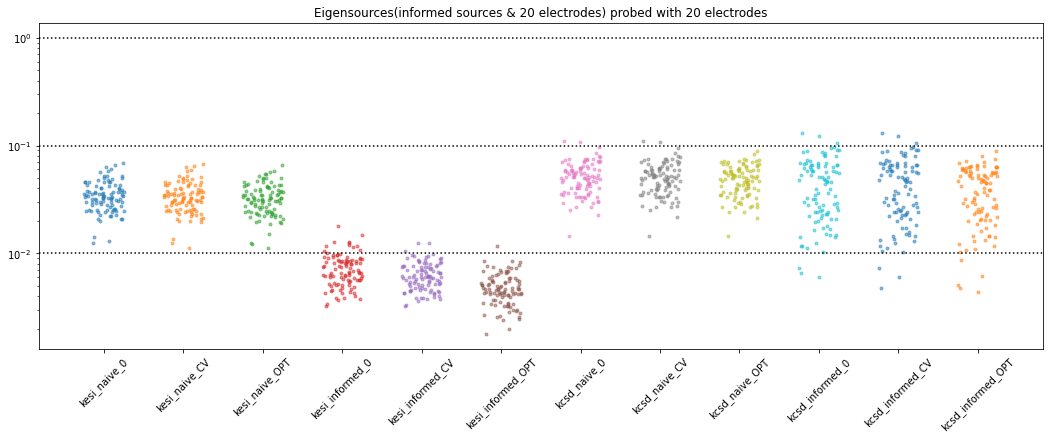

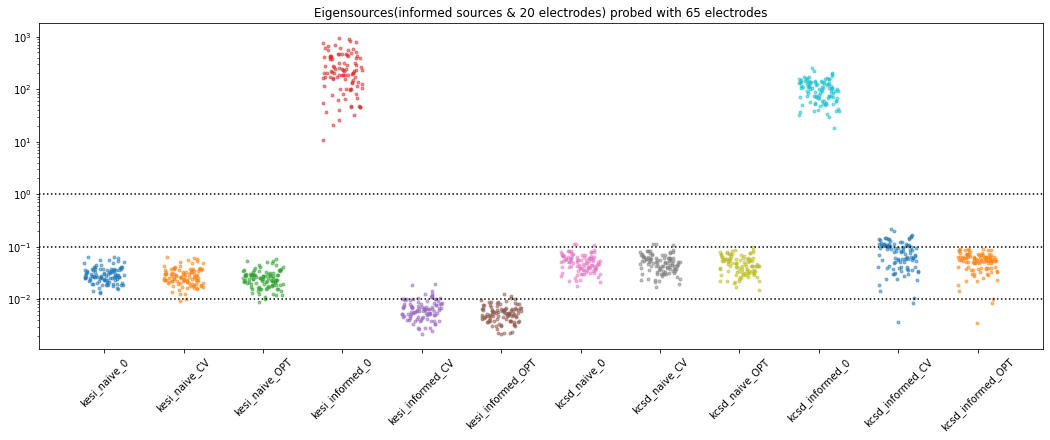

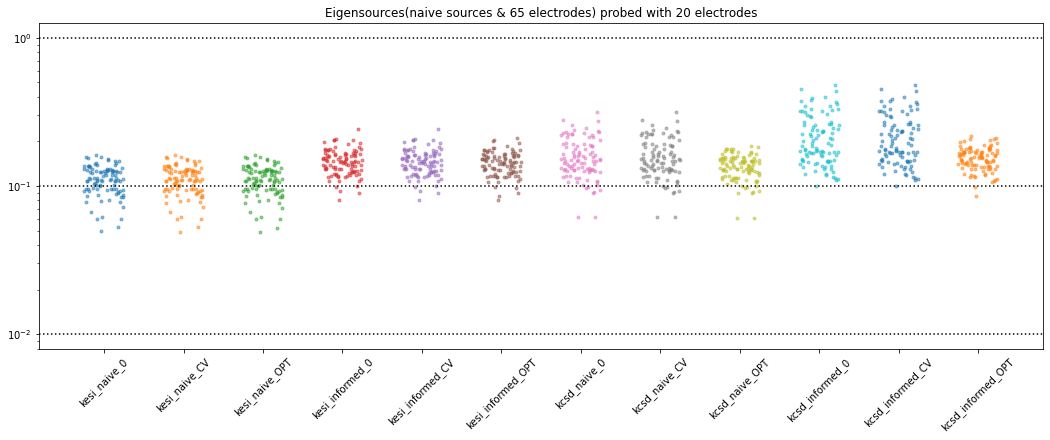

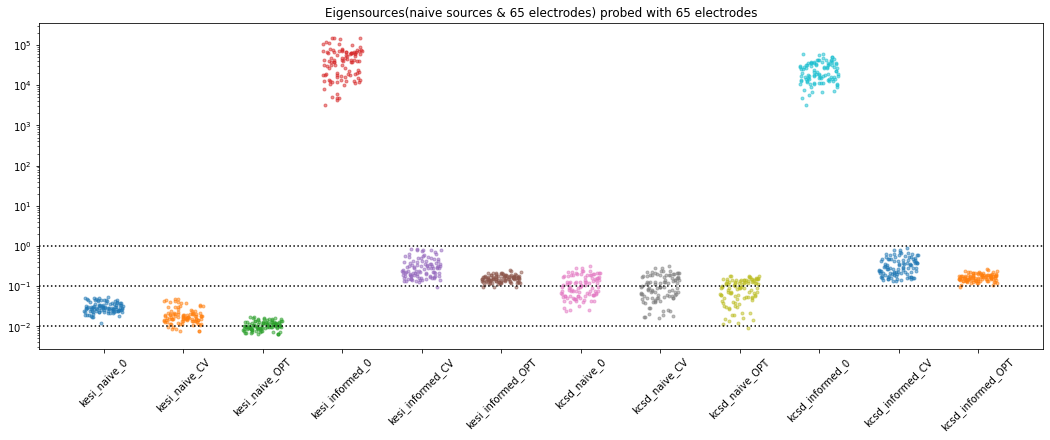

In [63]:
cols = [c for c in TMP.columns if c.startswith('RMSE_')]

for (_setup, _n_es, _n_rec), TMP in TEST_RESULTS.groupby(['SOURCES',
                                                          'ES_N_ELECTRODES',
                                                          'REC_N_ELECTRODES']):
    plt.figure(figsize=(18, 6))
    plt.title(f'Eigensources({_setup} sources & {_n_es} electrodes) probed with {_n_rec} electrodes')
    
    RND = np.random.uniform(-0.25, 0.25, len(TMP))
    for i, name in enumerate(cols):
        plt.scatter(RND + i,
                    TMP[name],
                    marker='.',
                    alpha=0.5)
        
    plt.xticks(range(len(cols)),
               [c[5:] for c in cols],
              rotation=45)
    plt.yscale('log')
    plt.axhline(1, ls=':', color=cbf.BLACK)
    plt.axhline(0.1, ls=':', color=cbf.BLACK)
    plt.axhline(0.01, ls=':', color=cbf.BLACK)
    

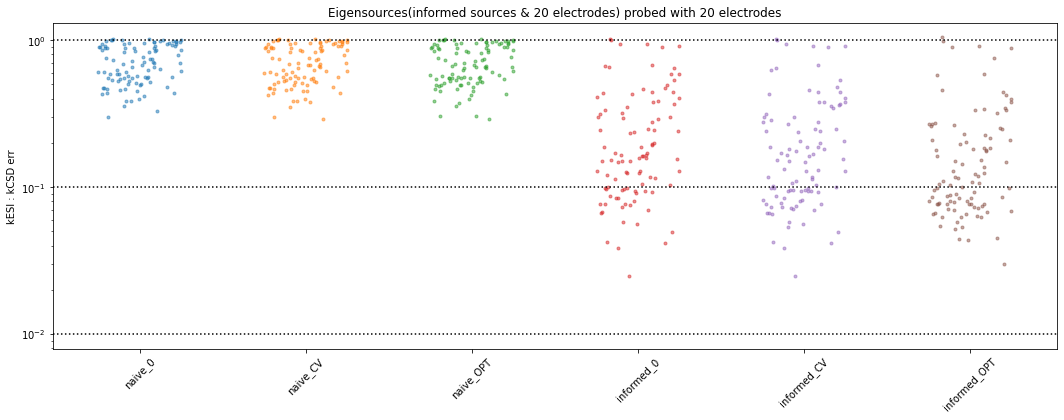

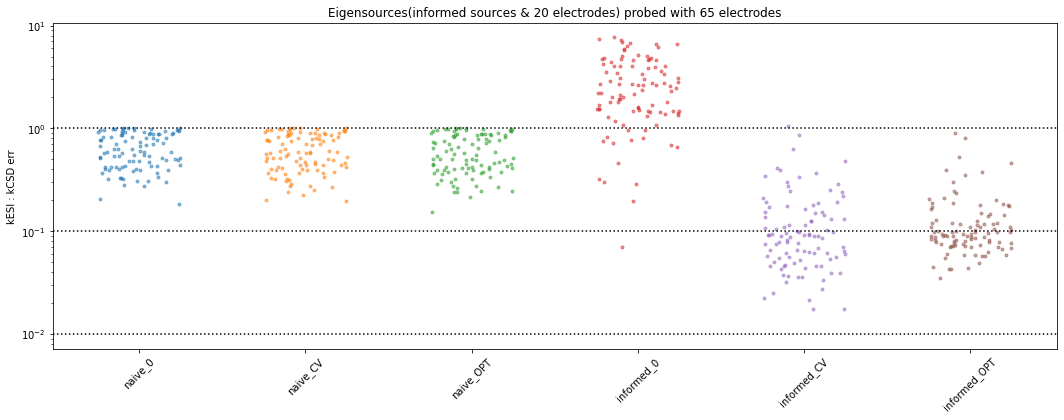

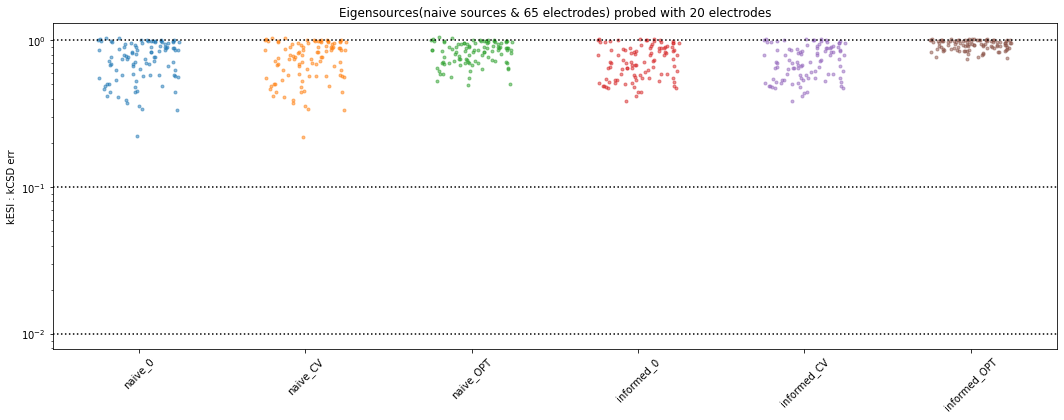

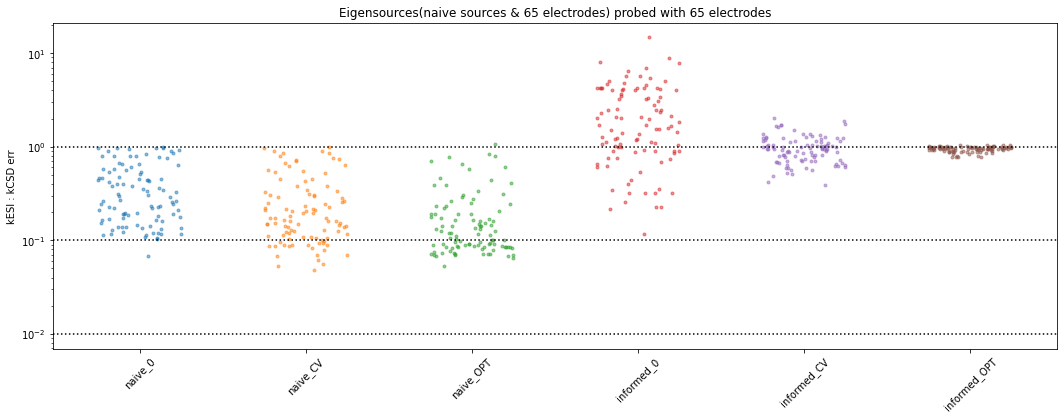

In [67]:
cols = [c for c in TMP.columns if c.startswith('RMSE_kesi_')]

for (_setup, _n_es, _n_rec), TMP in TEST_RESULTS.groupby(['SOURCES',
                                                          'ES_N_ELECTRODES',
                                                          'REC_N_ELECTRODES']):
    plt.figure(figsize=(18, 6))
    plt.title(f'Eigensources({_setup} sources & {_n_es} electrodes) probed with {_n_rec} electrodes')
    
    RND = np.random.uniform(-0.25, 0.25, len(TMP))
    for i, name in enumerate(cols):
        plt.scatter(RND + i,
                    TMP[name] / TMP[name.replace('kesi', 'kcsd')],
                    marker='.',
                    alpha=0.5)
        
    plt.xticks(range(len(cols)),
               [c[10:] for c in cols],
              rotation=45)
    plt.yscale('log')
    plt.ylabel('kESI : kCSD err')
    plt.axhline(1, ls=':', color=cbf.BLACK)
    plt.axhline(0.1, ls=':', color=cbf.BLACK)
    plt.axhline(0.01, ls=':', color=cbf.BLACK)
